In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Đọc file CSV
file_path = 'NLP DATASET.csv'  # Đường dẫn tới file CSV của bạn
data = pd.read_csv(file_path)
# 2. Kiểm tra định dạng dữ liệu
print("Dữ liệu ban đầu:")
print(data.head())
print("\nCác nhãn duy nhất trong dữ liệu:")
print(data['Label'].unique())


Dữ liệu ban đầu:
   STT                                           Question     Label
0    1                    Vì sao mèo ăn những vật thể lạ?       Why
1    2      Bạn đã chạy được bao nhiêu km trong tuần này?  Quantity
2    3  Tôi tính làm tủ áo cánh kính cửa lùa, có nên l...    Yes/No
3    4  Cách phòng ngừa và điều trị Búi lông “Hairball...       How
4    5  Bạn đã tham gia bao nhiêu buổi tư vấn nghề ngh...  Quantity

Các nhãn duy nhất trong dữ liệu:
['Why' 'Quantity' 'Yes/No' 'How' 'Who' 'Where' 'What' 'When']


In [52]:
from underthesea import word_tokenize
def preprocess_text(text):
    text = word_tokenize(text, format="text")  # Tách từ tiếng Việt
    text = text.lower()  # Chuyển về chữ thường
    return text

data['Question'] = data['Question'].apply(preprocess_text)


In [53]:
# Tách dữ liệu thành X (câu hỏi) và y (nhãn)
X = data['Question']
y = data['Label']

# Mã hóa nhãn thành số
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Chia tập dữ liệu thành train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=data['Label'])

print("Số lượng mẫu train:", len(X_train))
print("Số lượng mẫu test:", len(X_test))

Số lượng mẫu train: 960
Số lượng mẫu test: 240


In [54]:
print(data['Label'].head())  # Kiểm tra định dạng của cột `Label`


0         Why
1    Quantity
2      Yes/No
3         How
4    Quantity
Name: Label, dtype: object


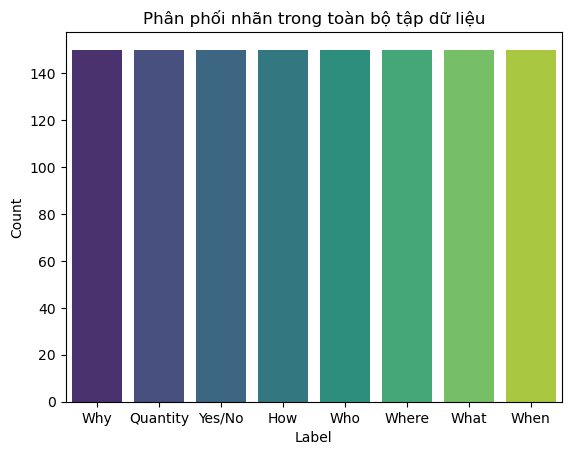

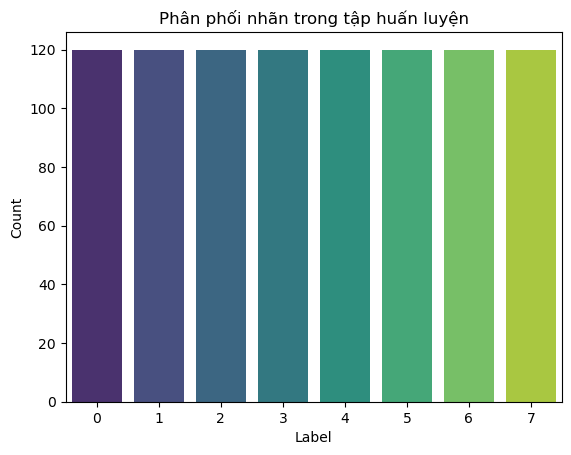

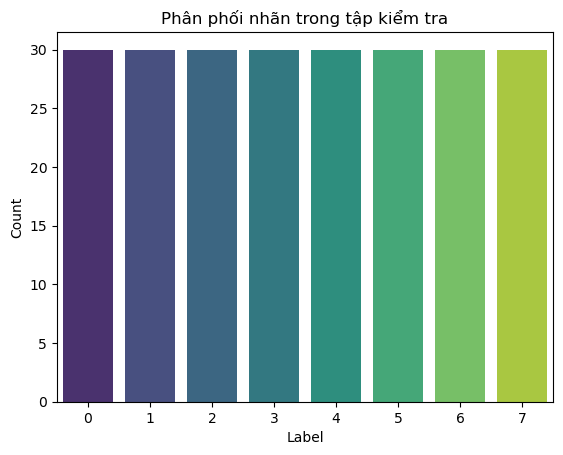

In [55]:
# 6. Vẽ biểu đồ phân phối nhãn
def plot_label_distribution(labels, title):
    sns.countplot(x=labels, palette="viridis")
    plt.title(title)
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.show()

# Phân phối nhãn trong toàn bộ dữ liệu
plot_label_distribution(data['Label'], "Phân phối nhãn trong toàn bộ tập dữ liệu")

# Phân phối nhãn trong tập huấn luyện
plot_label_distribution(y_train, "Phân phối nhãn trong tập huấn luyện")

# Phân phối nhãn trong tập kiểm tra
plot_label_distribution(y_test, "Phân phối nhãn trong tập kiểm tra")

In [56]:
# Khởi tạo Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Chuyển văn bản thành chuỗi số
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Đệm các chuỗi để có cùng độ dài
max_length = 50  # Giới hạn độ dài câu
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Kích thước từ điển
vocab_size = len(tokenizer.word_index) + 1
print("Số lượng từ trong từ điển:", vocab_size)


Số lượng từ trong từ điển: 1100


In [57]:
import fasttext

# Load FastText model từ file .bin
model = fasttext.load_model('cc.vi.300.bin')


In [58]:
print(model.get_word_vector('giá'))  # Lấy thử vector của từ "giá"

[-1.22661091e-01  5.53636700e-02  1.41800478e-01  2.95930430e-02
 -8.27335566e-02 -5.50692640e-02 -4.30196524e-02 -2.86210012e-02
  6.81398809e-03 -8.39588344e-02 -5.96411936e-02  1.42467842e-02
 -1.48809537e-01 -4.79608923e-02 -5.97199649e-02 -3.35736163e-02
  8.58044401e-02 -1.00587510e-01 -7.94519261e-02 -8.71512964e-02
  2.08056364e-02  2.36146394e-02  8.23296383e-02 -8.33525285e-02
  3.77636999e-02  5.23726568e-02  3.54800746e-02 -4.42538597e-02
  7.16536939e-02 -1.62647814e-01  7.43294656e-02  1.16684809e-01
 -7.64077231e-02 -8.51804018e-02 -3.61620262e-02 -9.03779045e-02
 -1.81313902e-02 -1.05658799e-01  1.35168731e-02  9.71468315e-02
 -4.03170474e-02  3.45492736e-02 -7.48830661e-02  8.72363336e-03
  9.43266004e-02  7.62426257e-02  8.72331560e-02 -2.75415480e-02
  1.46978237e-02 -7.19945133e-03  1.11510210e-01 -3.43572088e-02
  2.73421183e-02  1.02511436e-01 -1.04237944e-01 -3.46672311e-02
  1.58031583e-02 -4.98940386e-02 -2.75668688e-02  8.98529887e-02
 -4.55422811e-02 -1.39262

In [59]:
import numpy as np

# Khởi tạo embedding_matrix
embedding_matrix = np.zeros((vocab_size, 300))  # vocab_size là kích thước từ điển

# Tạo embedding matrix từ FastText
for word, idx in tokenizer.word_index.items():
    if idx < vocab_size:  # Đảm bảo chỉ số không vượt quá vocab_size
        embedding_matrix[idx] = model.get_word_vector(word)

print("Embedding matrix đã được khởi tạo.")
print("Shape của embedding matrix:", embedding_matrix.shape)


Embedding matrix đã được khởi tạo.
Shape của embedding matrix: (1100, 300)


In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Xây dựng mô hình
model = Sequential([
    Embedding(input_dim=vocab_size, 
              output_dim=300, 
              weights=[embedding_matrix], 
              input_shape=(max_length,),  
              trainable=False),
    Bidirectional(LSTM(units=128, return_sequences=False)),
    Dropout(0.5),
    Dense(units=64, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(units=8, activation='softmax')
])

# Compile mô hình
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Kiểm tra cấu trúc mô hình
model.summary()




/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 50, 300)        │       330,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 256)            │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 786,264 (3.00 MB)

 Trainable params: 456,264 (1.74 MB)

 Non-trainable params: 330,000 (1.26 MB)

In [72]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    X_train_padded,
    y_train,
    epochs=30,
    batch_size=16,
    validation_data=(X_test_padded, y_test),
    callbacks=[reduce_lr,early_stopping]
    
)


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.2271 - loss: 2.7999 - val_accuracy: 0.5583 - val_loss: 1.7447 - learning_rate: 0.0010
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6196 - loss: 1.5865 - val_accuracy: 0.7958 - val_loss: 1.0543 - learning_rate: 0.0010
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7959 - loss: 0.9625 - val_accuracy: 0.8667 - val_loss: 0.7957 - learning_rate: 0.0010
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8685 - loss: 0.7340 - val_accuracy: 0.8917 - val_loss: 0.6555 - learning_rate: 0.0010
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9022 - loss: 0.5639 - val_accuracy: 0.8667 - val_loss: 0.6524 - learning_rate: 0.0010
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9211 - loss: 0.4941 - val_accuracy: 0.9000 - val_loss: 0.5964 - learning_rate: 0.0010
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9420 - loss: 0.4195 - val_acc

In [73]:
# Đánh giá mô hình trên tập kiểm tra
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Độ chính xác trên tập kiểm tra: {accuracy * 100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8852 - loss: 0.5507
Độ chính xác trên tập kiểm tra: 90.42%


In [74]:
def predict_question(question):
    # Tokenize và pad câu hỏi
    sequence = tokenizer.texts_to_sequences([question])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    
    # Dự đoán
    prediction = model.predict(padded_sequence)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label[0]

# Dự đoán câu hỏi mới
new_question = "Tôi muốn biết tổng thống nước Mỹ bây giờ là ai?"
print("Loại câu hỏi:", predict_question(new_question))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Loại câu hỏi: Who


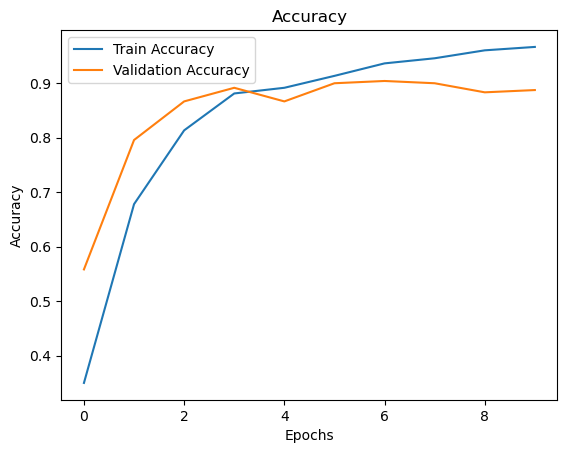

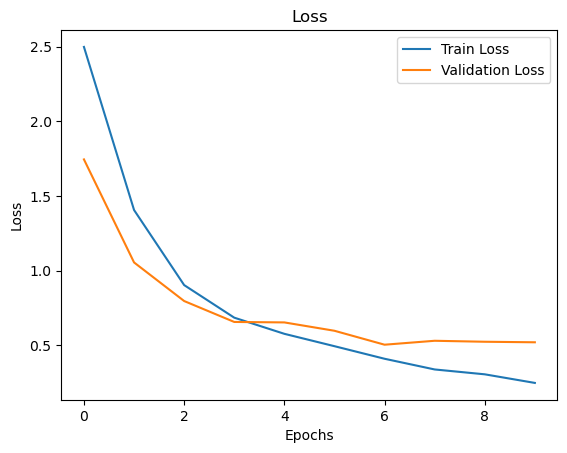

In [75]:
import matplotlib.pyplot as plt

# Vẽ đồ thị accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Vẽ đồ thị loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [76]:
model.save('lstm_fasttext_model.h5')
import joblib
joblib.dump(tokenizer, 'tokenizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']